In [1]:
import sys
sys.path.insert(1, '../../../utils')
import numpy as np
from numpy import log, ndarray, array, mean, sqrt, arange
from pandas import read_csv, DataFrame, Series, to_timedelta, date_range, to_datetime, concat
from matplotlib.pyplot import figure, savefig, show, subplots, plot, legend, setp
from matplotlib.figure import Figure
from matplotlib.axes import Axes
from matplotlib.gridspec import GridSpec
from dslabs_functions import plot_line_chart, HEIGHT, ts_aggregation_by, set_chart_labels, plot_components, plot_multiline_chart, \
    series_train_test_split, plot_forecasting_series, plot_multibar_chart, FORECAST_MEASURES, plot_forecasting_eval, plot_forecasting_series, \
    PersistenceOptimistRegressor, PersistenceRealistRegressor, scale_all_dataframe, \
    exponential_smoothing_study, rolling_mean_study, arima_study, arima_study_forecasting, DS_LSTM, lstm_study, prepare_dataset_for_lstm, \
    DS_LSTM_Multivariate, lstm_study_multivariate, prepare_multivariate_dataset_for_lstm
from studies import mlp_study_forecast
from scipy.stats import norm, expon, lognorm
from seaborn import heatmap
from statsmodels.tsa.stattools import adfuller
from sklearn.base import RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, r2_score
from statsmodels.tsa.arima.model import ARIMA

Target: Total
Exogenous variables: ['CarCount', 'BikeCount', 'BusCount', 'TruckCount']

Train shape: (176,), Train exog shape: (176, 4)
Test shape: (51,), Test exog shape: (51, 4)


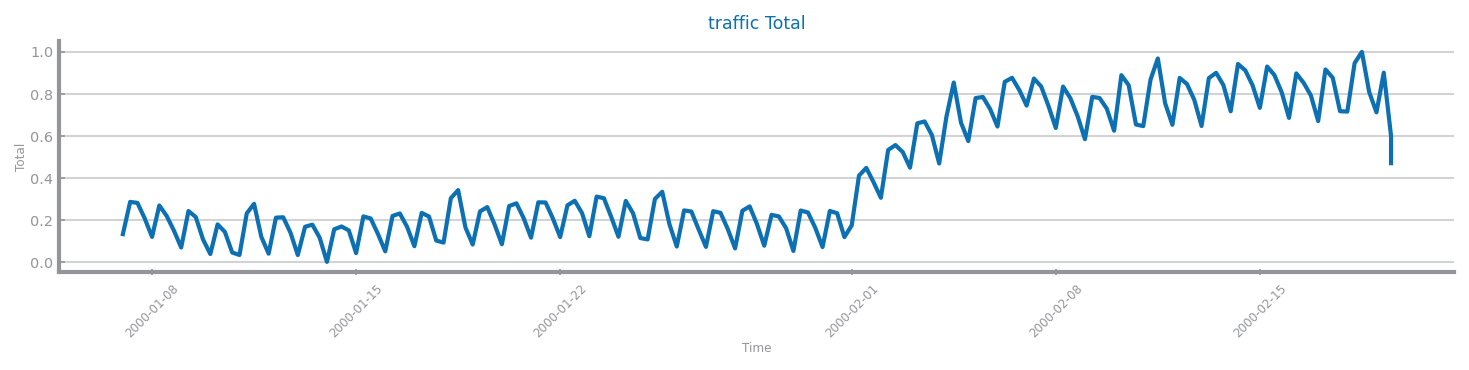

In [2]:
target = "Total"
chart_target = "Total"
file_tag = "traffic"
timecol = "timestamp"

train_path = "../data/prepared/scaling/traffic_train_scaling.csv" 
test_path  = "../data/prepared/scaling/traffic_test_scaling.csv"

train_df = read_csv(train_path, parse_dates=["Time"], index_col="Time")
train: Series = train_df[target]
train.index = to_datetime(train.index)  # ensure proper datetime index

# Prepare exogenous variables (all columns except target)
exog_cols = [col for col in train_df.columns if col != target]
train_exog = train_df[exog_cols]

# Load test
test_df = read_csv(test_path, parse_dates=["Time"], index_col="Time")
test: Series = test_df[target]
test.index = to_datetime(test.index)

# Prepare test exogenous variables
test_exog = test_df[exog_cols]

print(f"Target: {target}")
print(f"Exogenous variables: {exog_cols}")
print(f"\nTrain shape: {train.shape}, Train exog shape: {train_exog.shape}")
print(f"Test shape: {test.shape}, Test exog shape: {test_exog.shape}")

figure(figsize=(3 * HEIGHT, HEIGHT / 2))
plot_line_chart(
    train.index.to_list(),
    train.to_list(),
    xlabel=train.index.name,
    ylabel=target,
    title=f"{file_tag} {target}",
)
show()

In [3]:
test.head()

Time
2000-02-19 12:00:00    0.599499
2000-02-19 12:00:00    0.470063
2000-02-19 18:00:00    0.465600
2000-02-20 00:00:00    0.486283
2000-02-20 06:00:00    0.471478
Name: Total, dtype: float64

## Exponential Smoothing

Exponential Smoothing best with alpha=0.3 -> R2=-0.008326672809857438


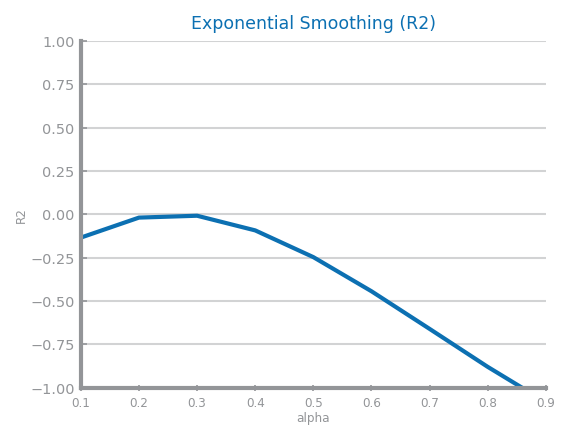

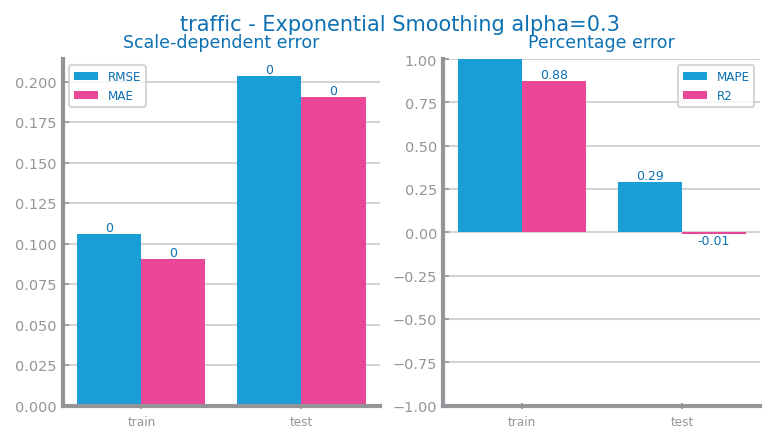

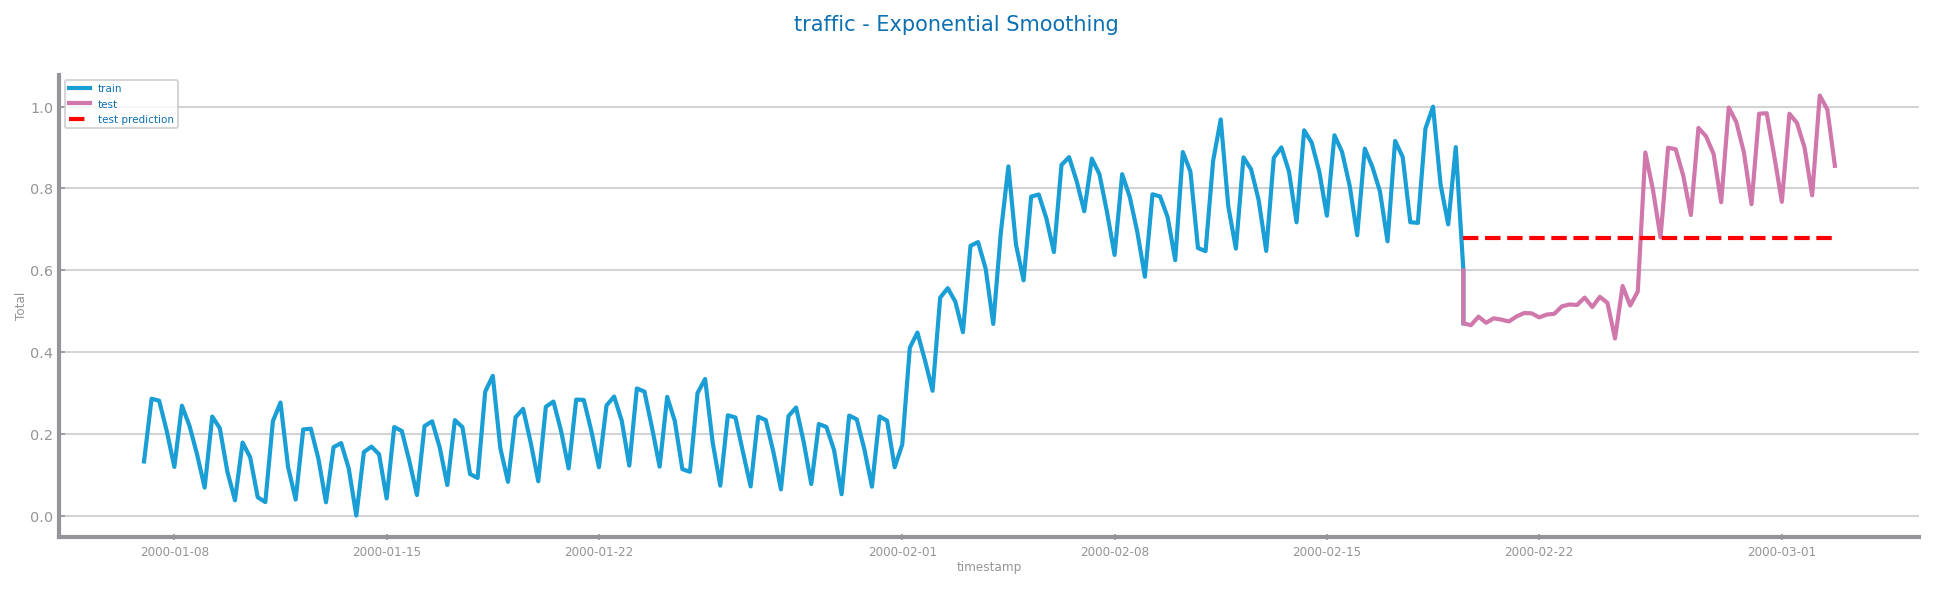

Exponential Smoothing best with alpha=0.7 -> MAPE=0.2378882592083769


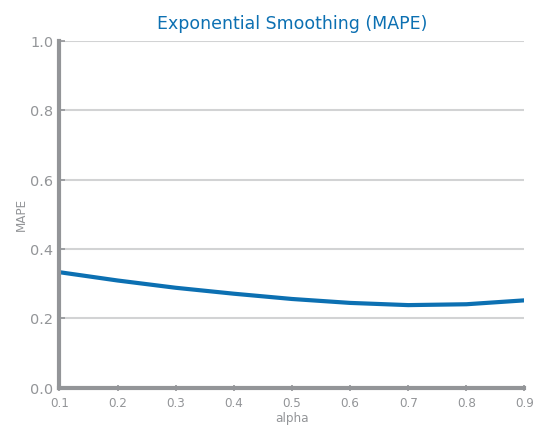

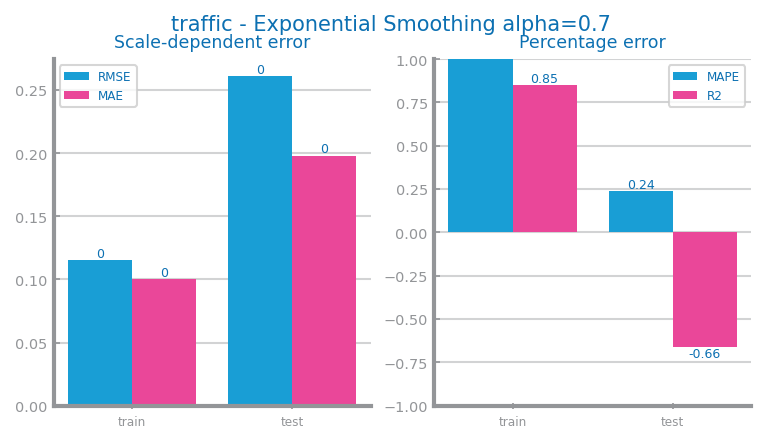

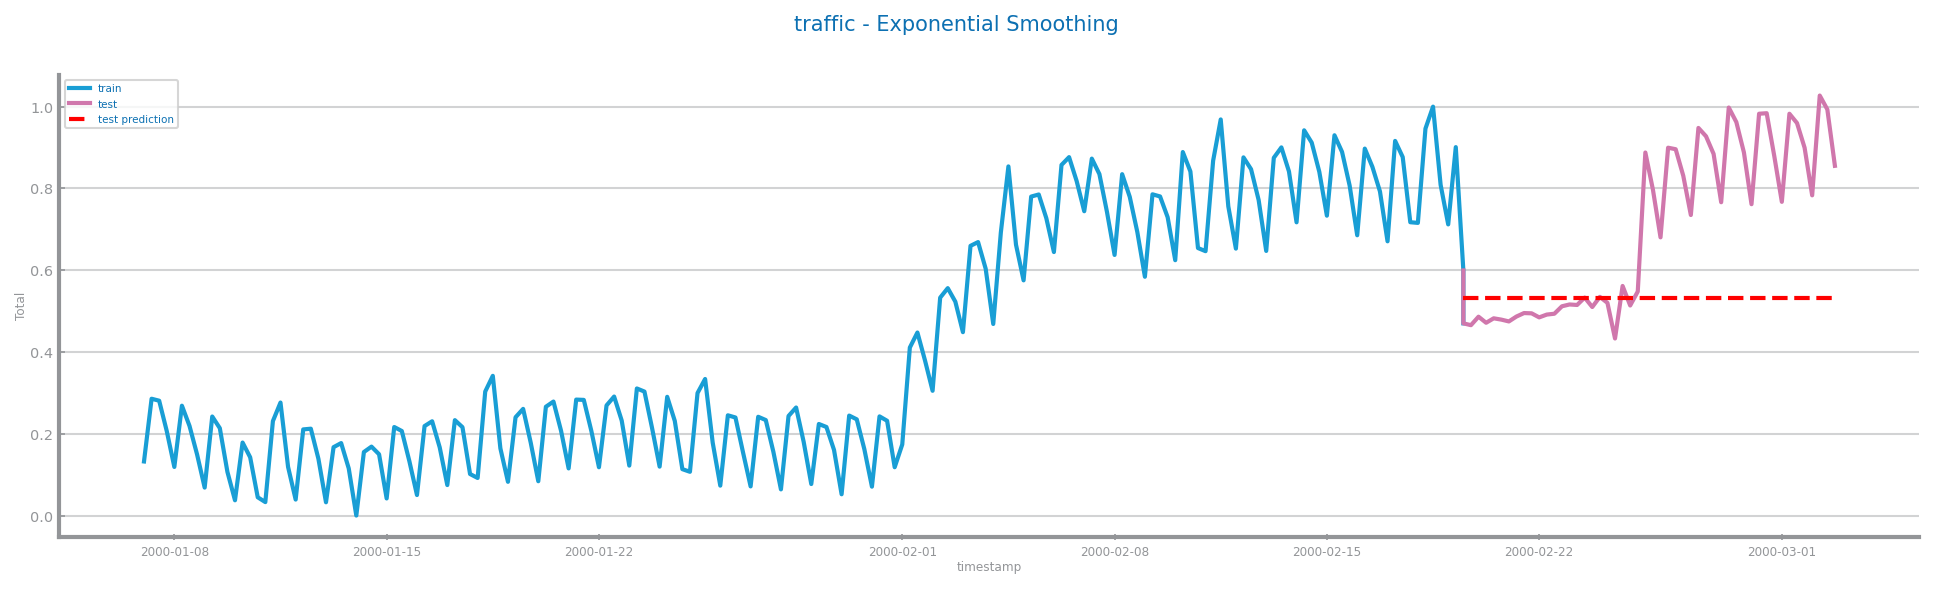

In [4]:
measures = ["R2","MAPE"]
for measure in measures:
    best_model, best_params = exponential_smoothing_study(train, test, measure=measure)
    # savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_study.png")
    # show()

    params = best_params["params"]
    prd_trn = best_model.predict(start=0, end=len(train) - 1)
    prd_tst = Series(best_model.forecast(steps=len(test)).values, index=test.index)

    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - Exponential Smoothing alpha={params[0]}")
    savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - Exponential Smoothing ",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_exponential_smoothing_{measure}_forecast.png")
    show()      

## Multi-Layer Perceptron

MLP best for 1500 iterations (lr_type=adaptive and lr=0.05


<Figure size 600x600 with 0 Axes>

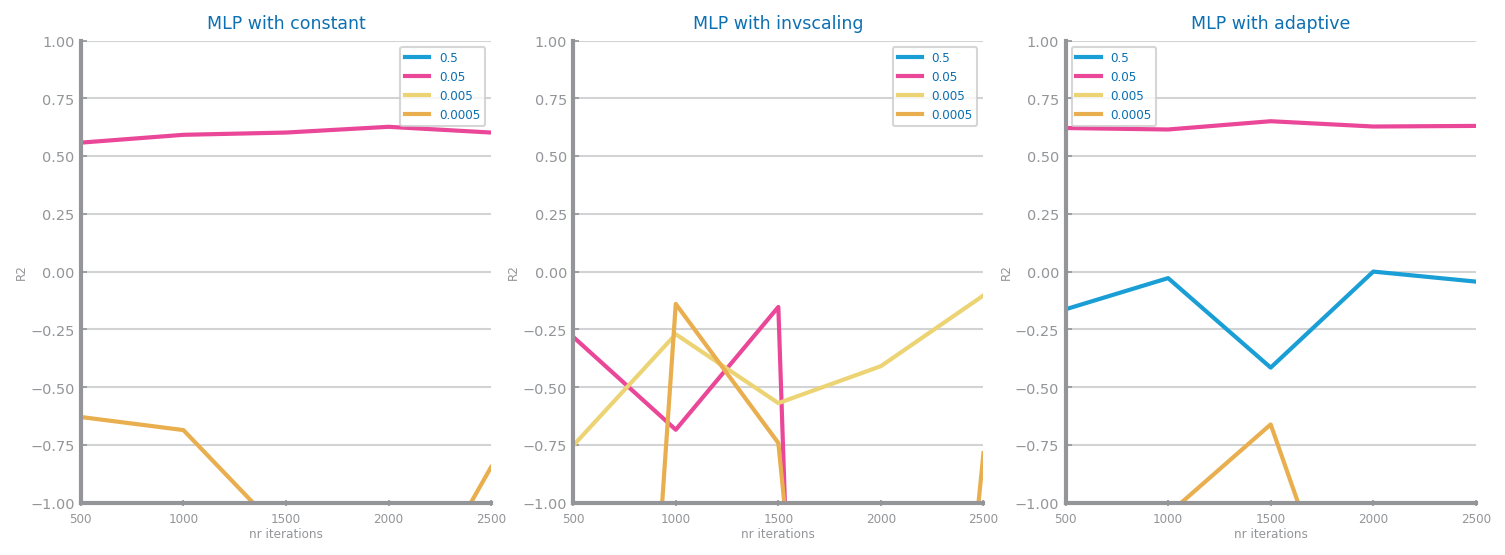

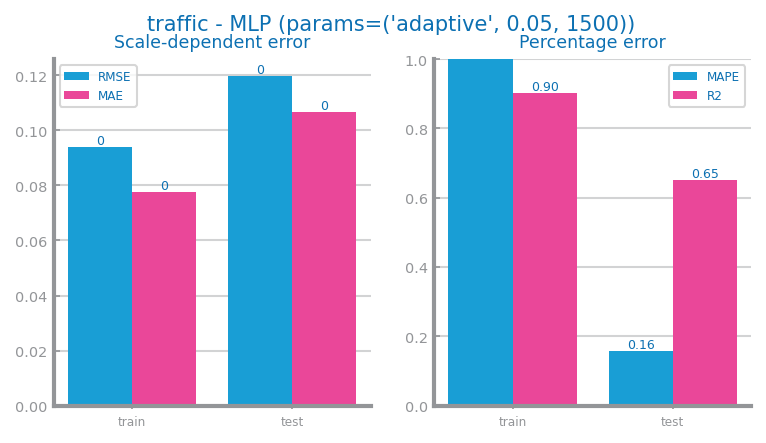

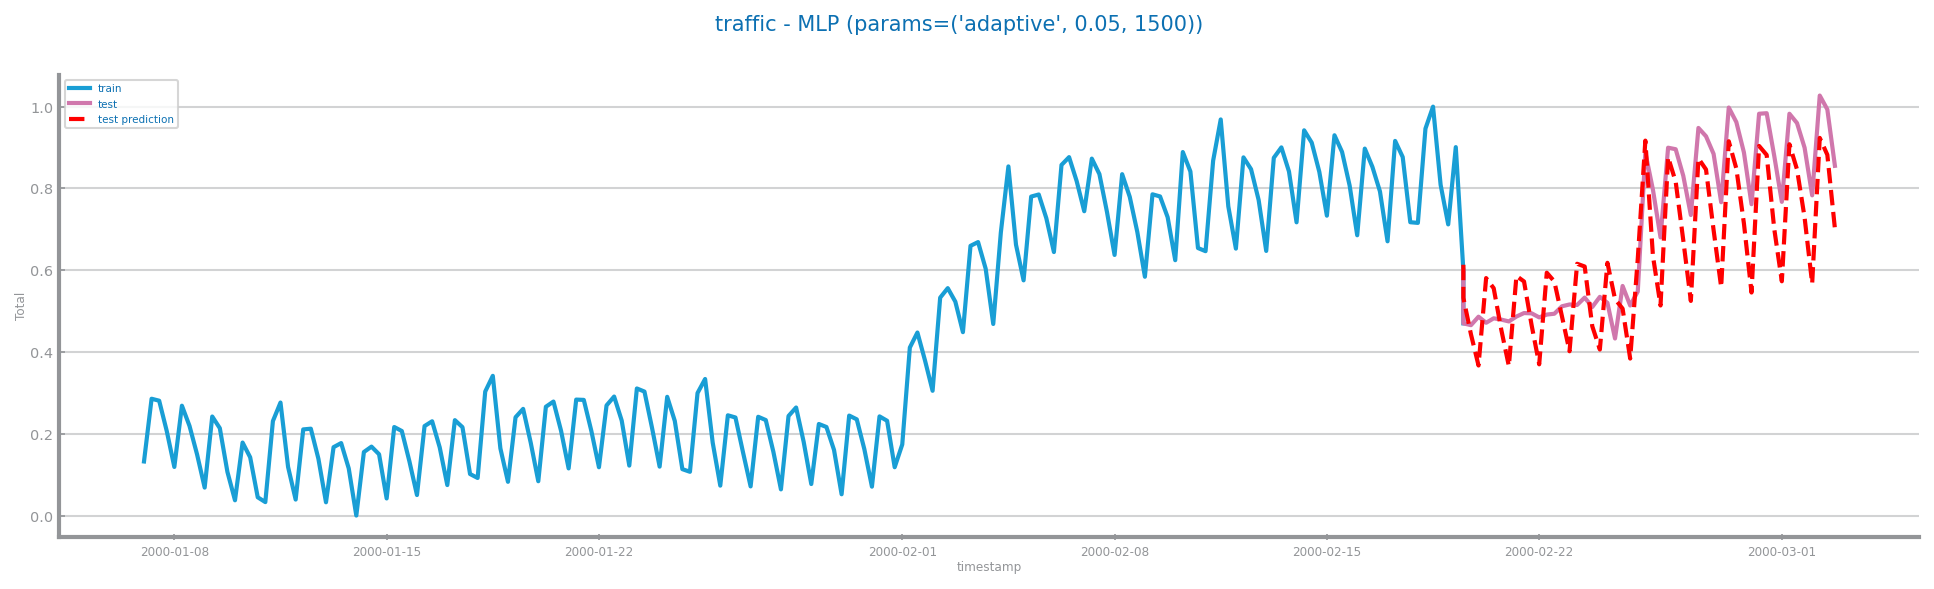

MLP best for 500 iterations (lr_type=constant and lr=0.5


<Figure size 600x600 with 0 Axes>

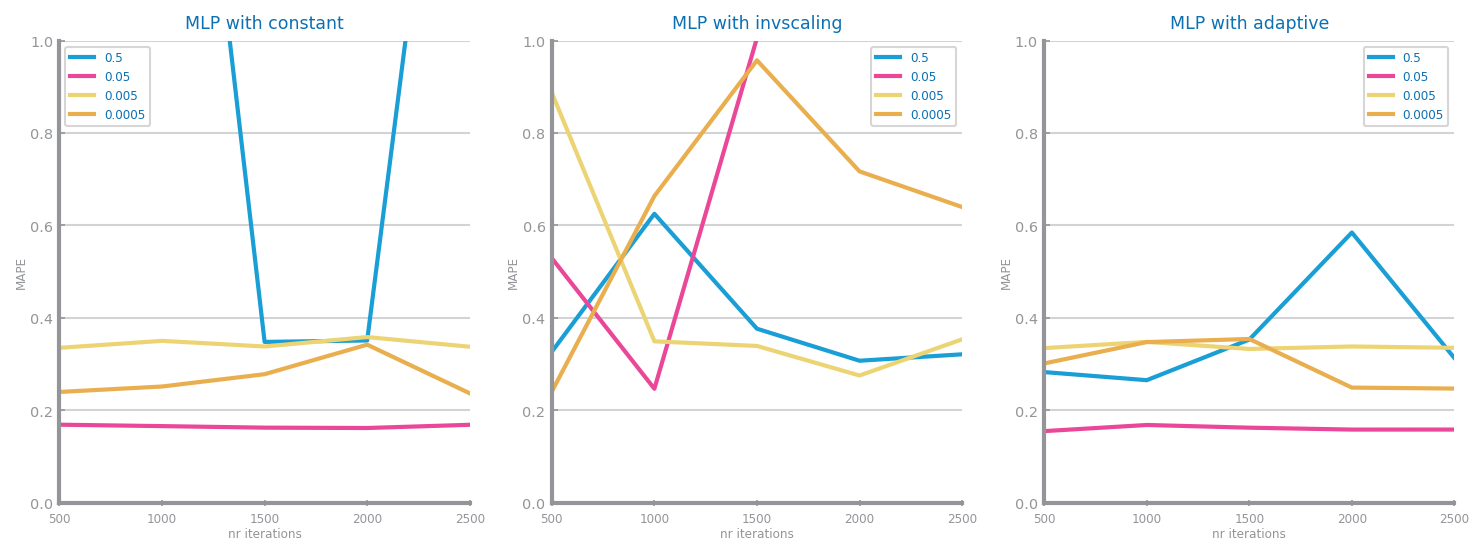

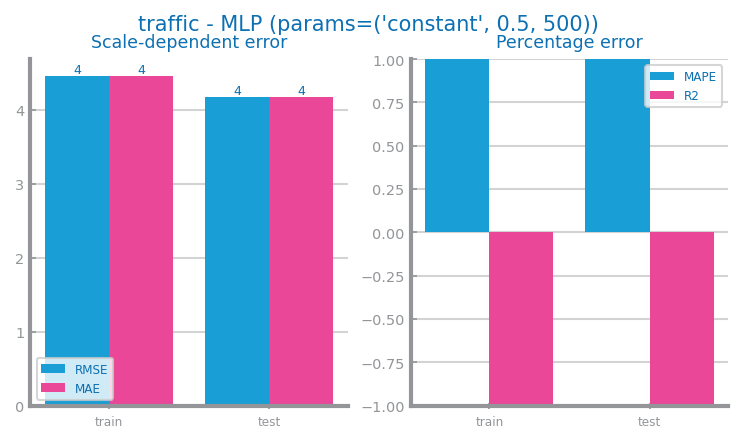

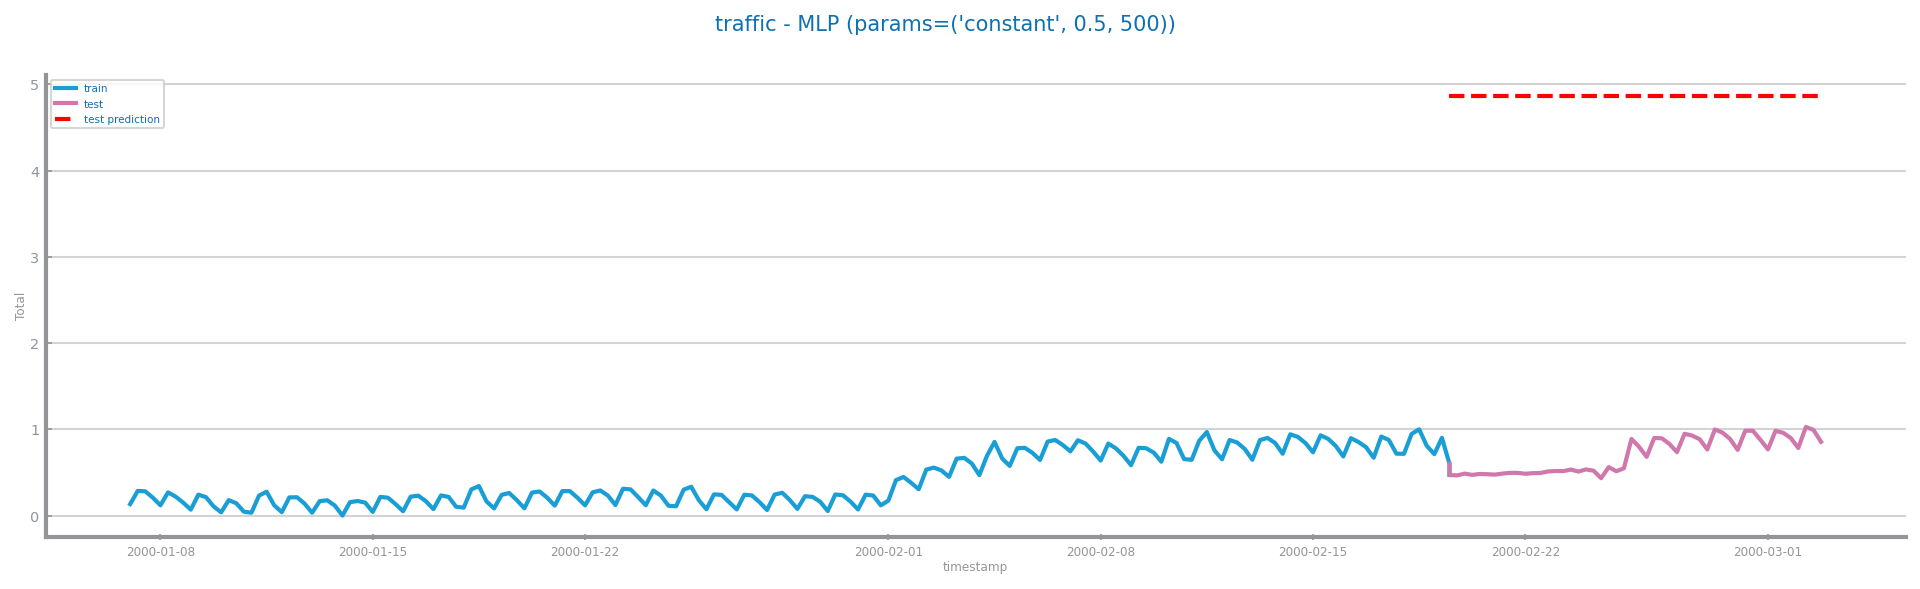

In [5]:
measures = ["R2","MAPE"]
for measure in measures:
    fig = figure(figsize=(HEIGHT, HEIGHT))
    best_model, best_params = mlp_study_forecast(train_df, train_df['Total'], test_df, test_df['Total'], measure=measure)
    savefig(f"../charts/forecasting/{file_tag}_mlp_{measure}_study.png")
    show()

    params = best_params["params"]
    prd_trn = Series(best_model.predict(train_df), index=train_df.index)
    prd_tst = Series(best_model.predict(test_df), index=test_df.index)
    plot_forecasting_eval(train, test, prd_trn, prd_tst, title=f"{file_tag} - MLP (params={params})")
    savefig(f"../charts/forecasting/{file_tag}_mlp_{measure}_params{params}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - MLP (params={params})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_mlp_{measure}_forecast.png")
    show()      

## ARIMA

In [6]:
# ARIMA with exogenous variables
predictor = ARIMA(train, exog=train_exog, order=(3, 1, 2))
model = predictor.fit()
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                  Total   No. Observations:                  176
Model:                 ARIMA(3, 1, 2)   Log Likelihood                 328.843
Date:                Thu, 18 Dec 2025   AIC                           -637.686
Time:                        21:33:09   BIC                           -606.038
Sample:                             0   HQIC                          -624.849
                                - 176                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
CarCount       0.1914      0.023      8.416      0.000       0.147       0.236
BikeCount      0.1231      0.024      5.039      0.000       0.075       0.171
BusCount       0.0845      0.016      5.390      0.0

In [7]:
test_df.head()

,Total,CarCount,BikeCount,BusCount,TruckCount
Time,,,,,
2000-02-19 12:00:00,0.599499,0.387935,0.290481,0.504261,0.133408
2000-02-19 12:00:00,0.470063,0.387935,0.290481,0.504261,0.133408
2000-02-19 18:00:00,0.465600,0.425220,0.291462,0.367898,0.529148
2000-02-20 00:00:00,0.486283,0.153749,0.092247,0.024148,0.582960
2000-02-20 06:00:00,0.471478,0.664013,0.370952,0.884943,0.251121


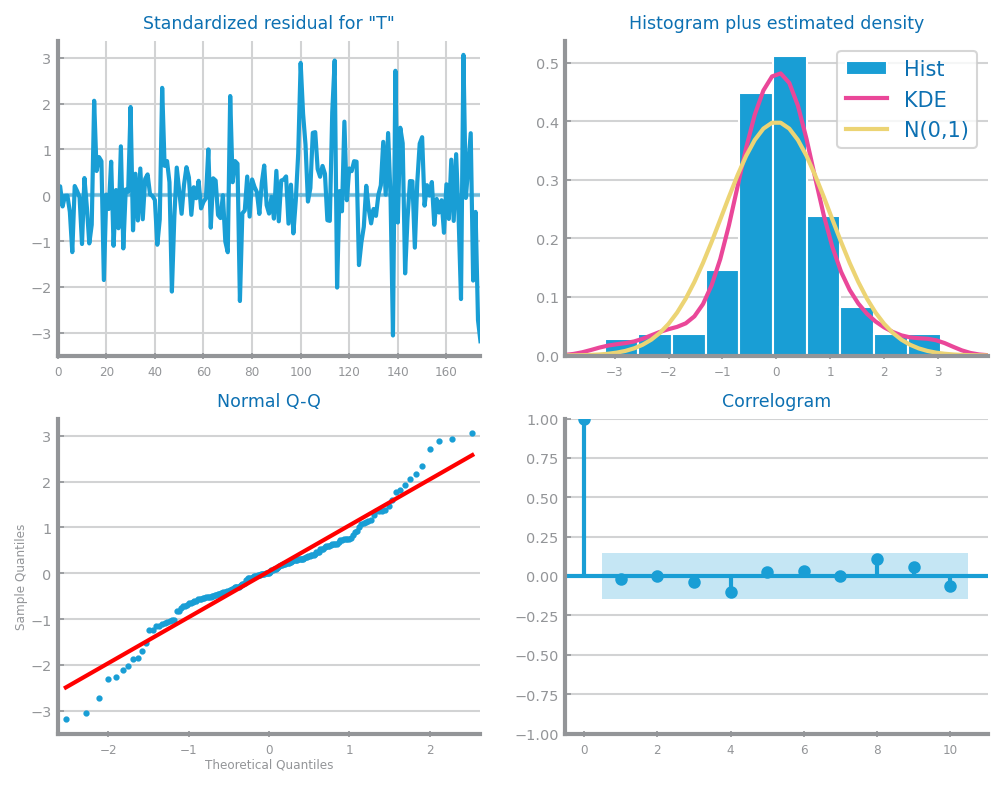

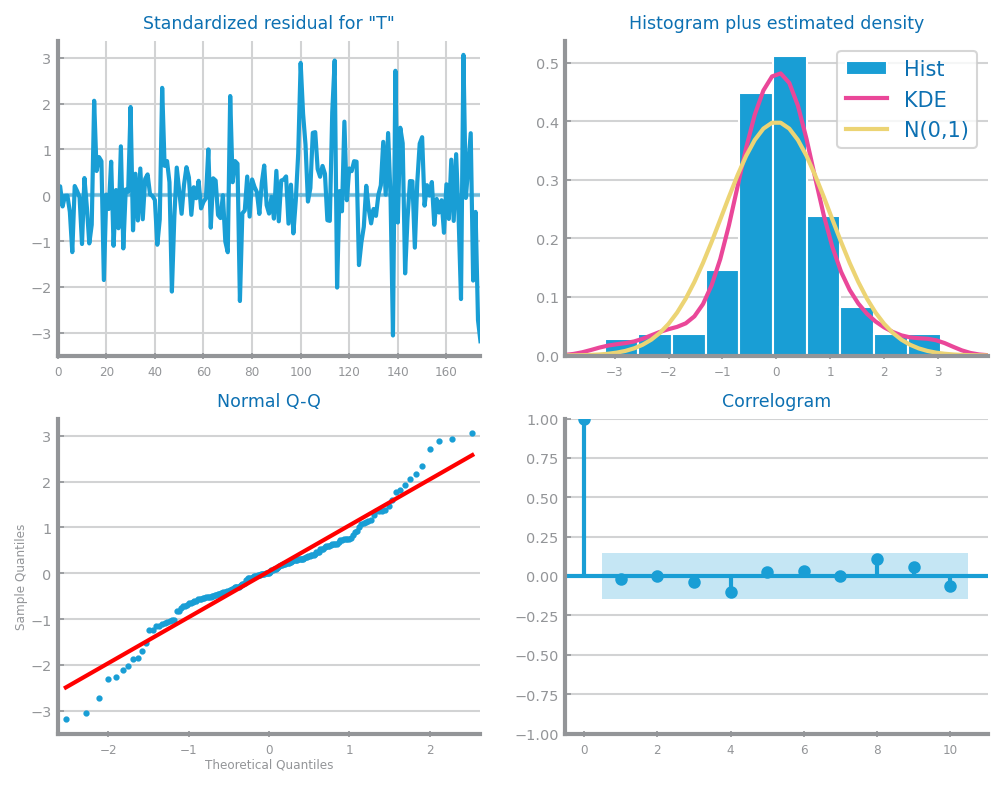

In [8]:
model.plot_diagnostics(figsize=(2 * HEIGHT, 1.5 * HEIGHT))

ARIMA best results achieved with (p,d,q)=(1, 2, 3) ==> measure=0.14


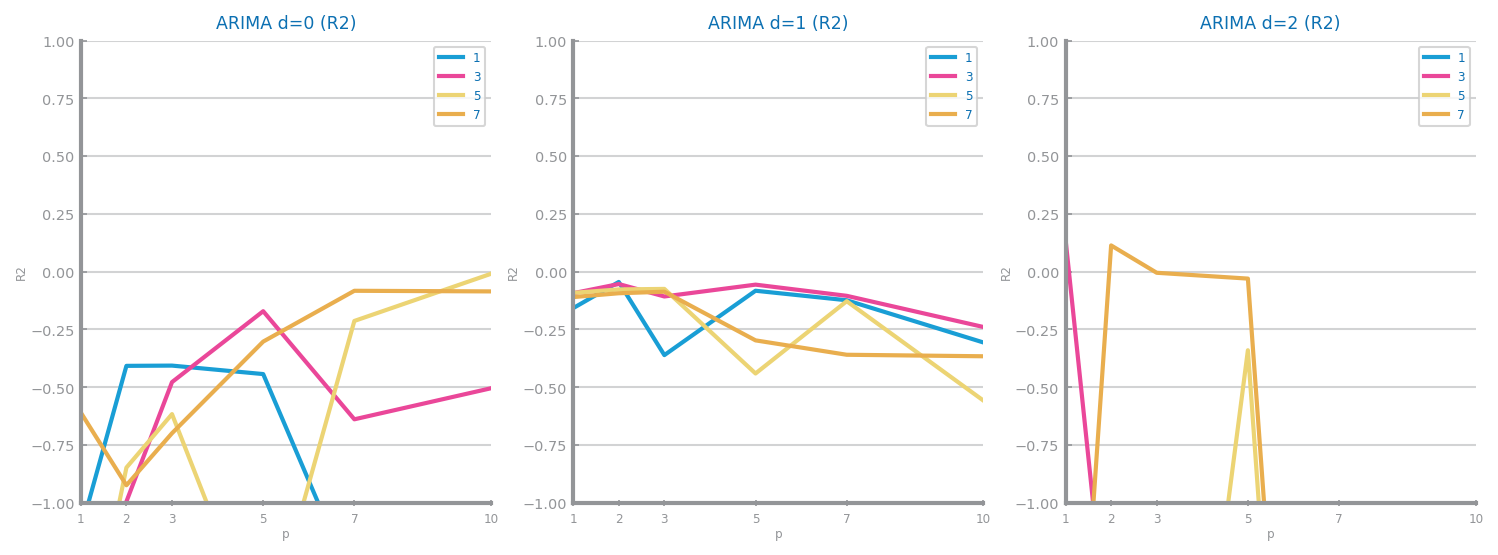

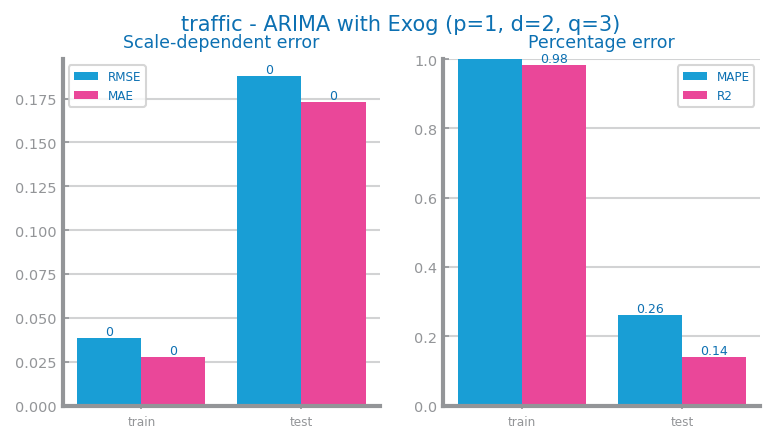

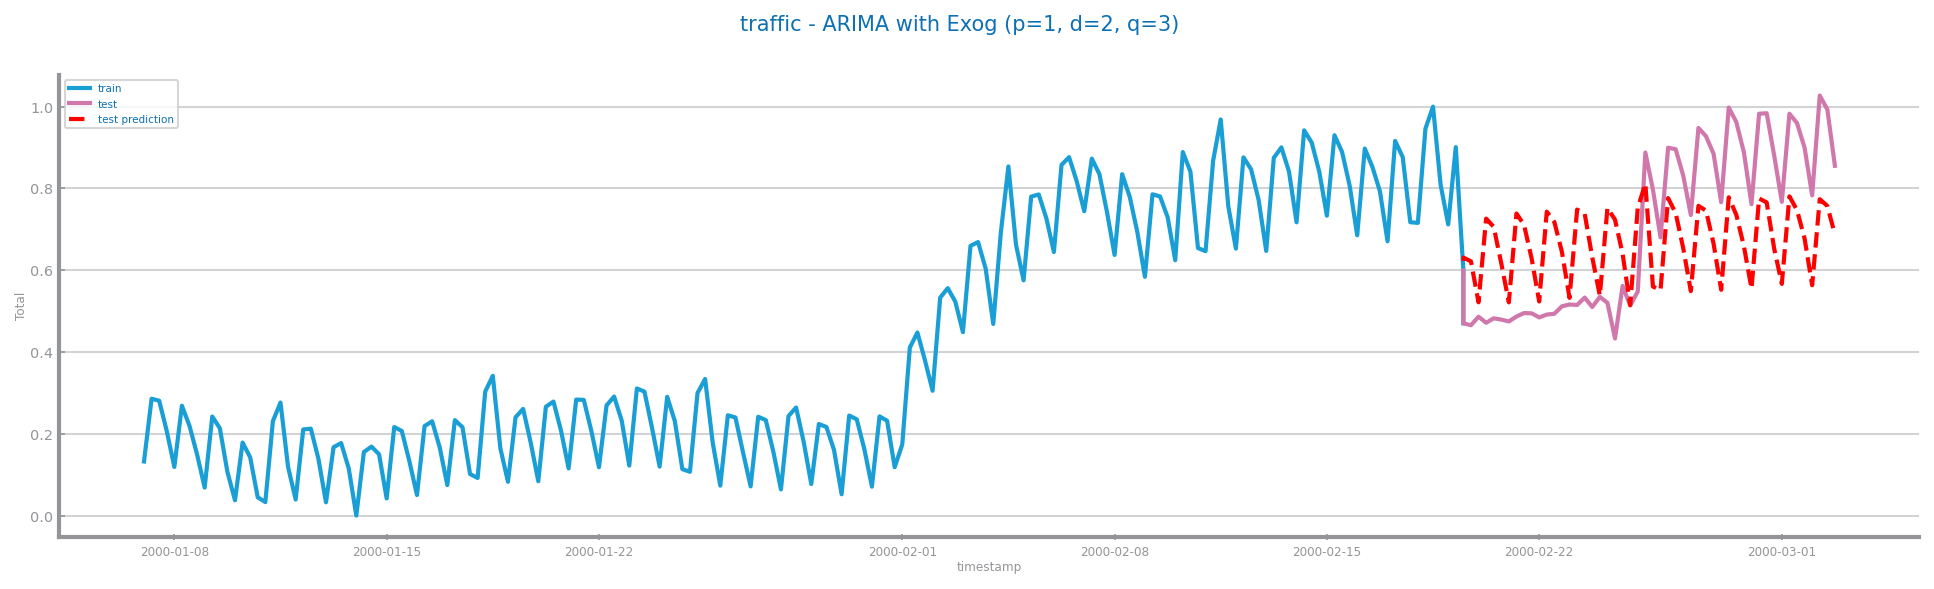

ARIMA best results achieved with (p,d,q)=(7, 2, 3) ==> measure=2.09


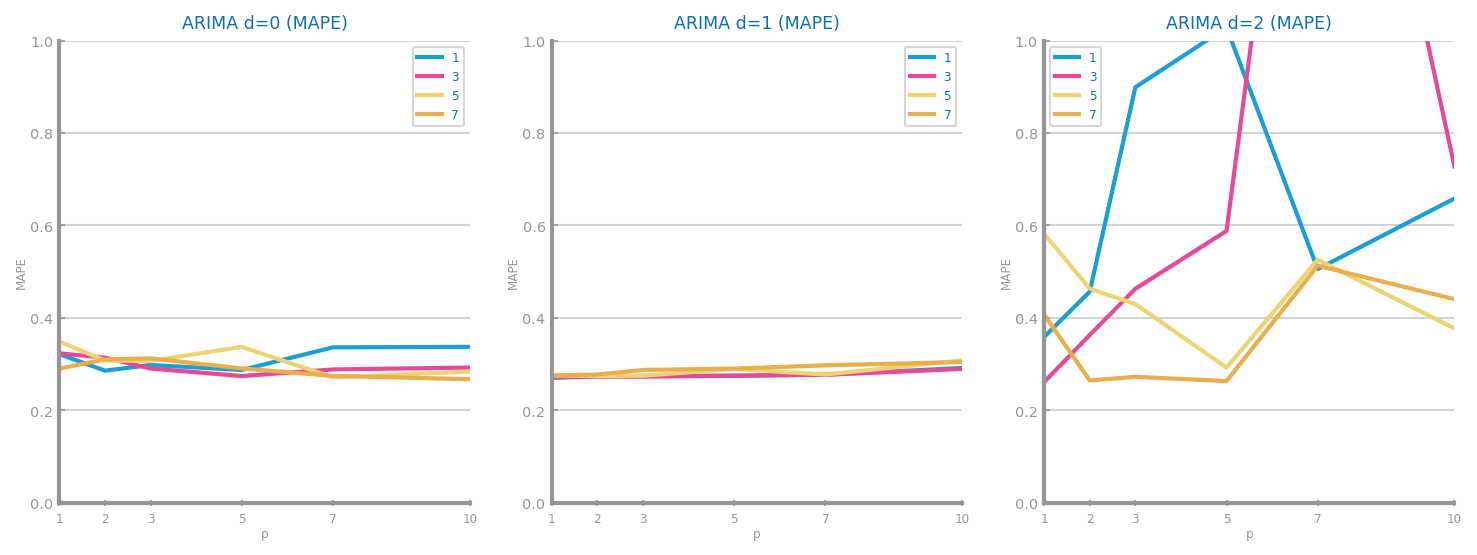

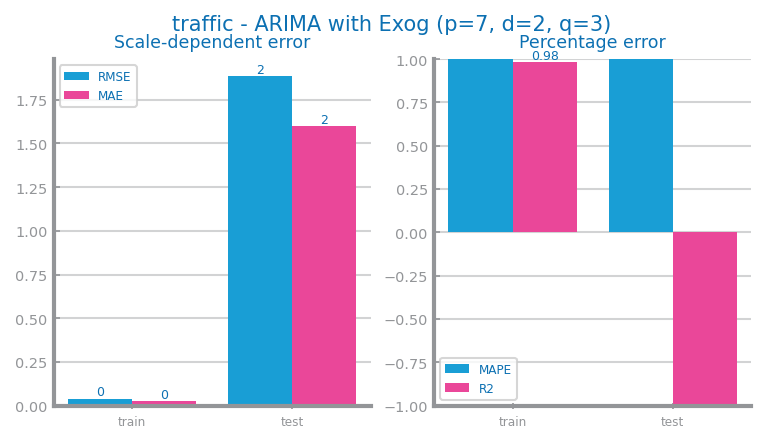

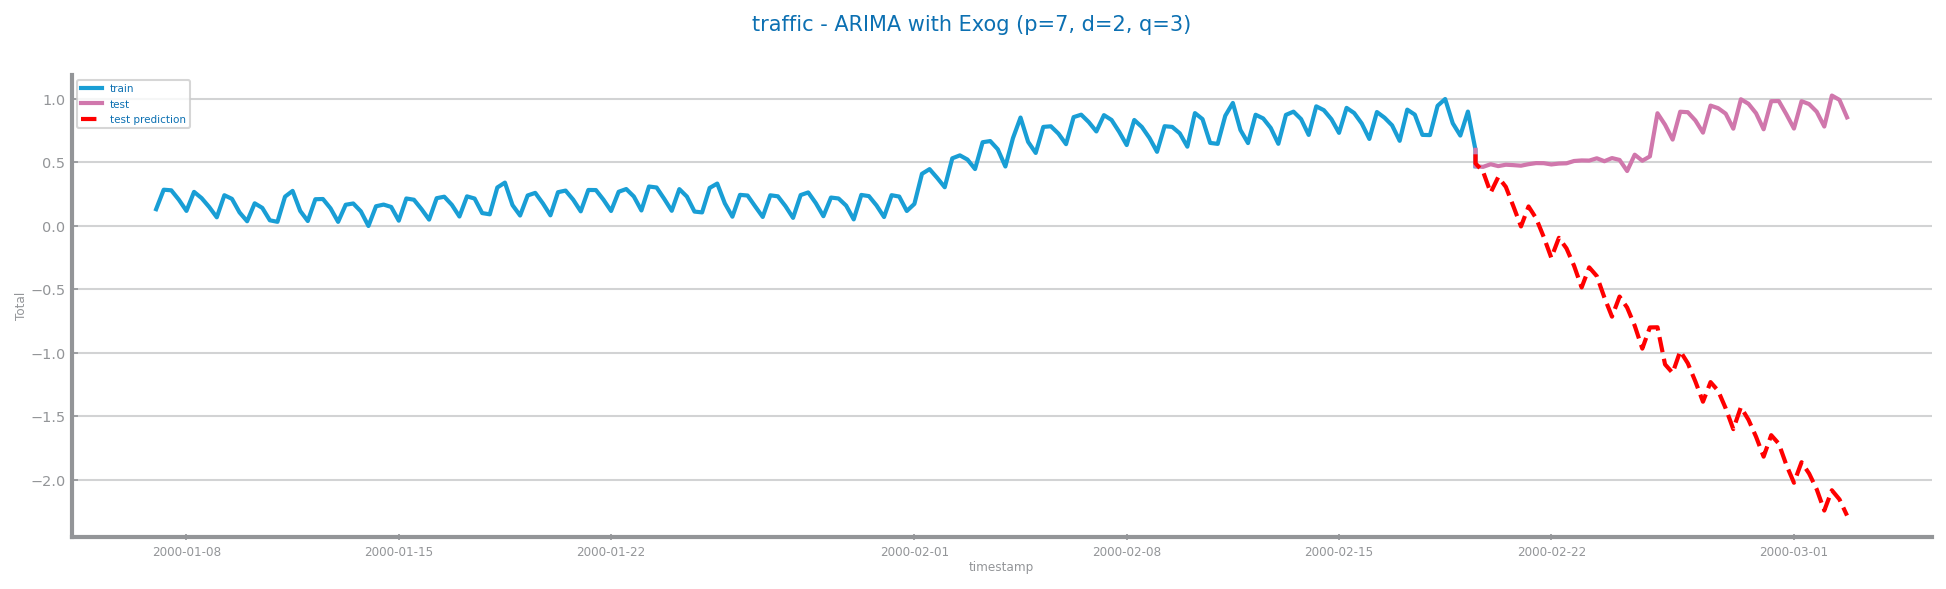

In [9]:
measures = ["R2","MAPE"]
for measure in measures:
    # Use arima_study_forecasting with exogenous variables
    best_model, best_params = arima_study_forecasting(train, test, measure=measure, exog_train=train_exog, exog_test=test_exog)
    savefig(f"../charts/forecasting/{file_tag}_arima_exog_{measure}_study.png")
    show()

    params = best_params["params"]
    # For predictions with exog, we need to provide exog data
    prd_trn = best_model.predict(start=0, end=len(train) - 1, exog=train_exog)
    prd_tst = Series(best_model.forecast(steps=len(test), exog=test_exog).values, index=test.index)

    plot_forecasting_eval(
        train, test, prd_trn, prd_tst, title=f"{file_tag} - ARIMA with Exog (p={params[0]}, d={params[1]}, q={params[2]})"
    )
    savefig(f"../charts/forecasting/{file_tag}_arima_exog_{measure}_eval.png")
    show()

    plot_forecasting_series(
        train,
        test,
        prd_tst,
        title=f"{file_tag} - ARIMA with Exog (p={params[0]}, d={params[1]}, q={params[2]})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_arima_exog_{measure}_forecast.png")
    show()

## LSTMs

In [10]:
from dslabs_functions import DS_LSTM_Inflation, prepare_dataset_for_lstm_inflation, lstm_study_inflation

train_lstm = train.astype("float32")
test_lstm = test.astype("float32")

model = DS_LSTM_Inflation(train_lstm, input_size=1, hidden_size=50, num_layers=1, length=4)
loss = model.fit()
print(loss)

tensor(0.3594, grad_fn=<MseLossBackward0>)


seq length=1 hidden_units=25 nr_episodes=0 0.5267972946166992
seq length=1 hidden_units=25 nr_episodes=300 0.10878846794366837
seq length=1 hidden_units=25 nr_episodes=600 0.10873483121395111
seq length=1 hidden_units=25 nr_episodes=900 0.10595241189002991
seq length=1 hidden_units=25 nr_episodes=1200 0.10679391771554947
seq length=1 hidden_units=25 nr_episodes=1500 0.1060909554362297
seq length=1 hidden_units=25 nr_episodes=1800 0.10784533619880676
seq length=1 hidden_units=25 nr_episodes=2100 0.11570749431848526
seq length=1 hidden_units=25 nr_episodes=2400 0.11388526856899261
seq length=1 hidden_units=25 nr_episodes=2700 0.11761648952960968
seq length=1 hidden_units=25 nr_episodes=3000 0.11735758185386658
seq length=1 hidden_units=50 nr_episodes=0 0.6688086986541748
seq length=1 hidden_units=50 nr_episodes=300 0.10914572328329086
seq length=1 hidden_units=50 nr_episodes=600 0.10982286930084229
seq length=1 hidden_units=50 nr_episodes=900 0.1087961494922638
seq length=1 hidden_units=

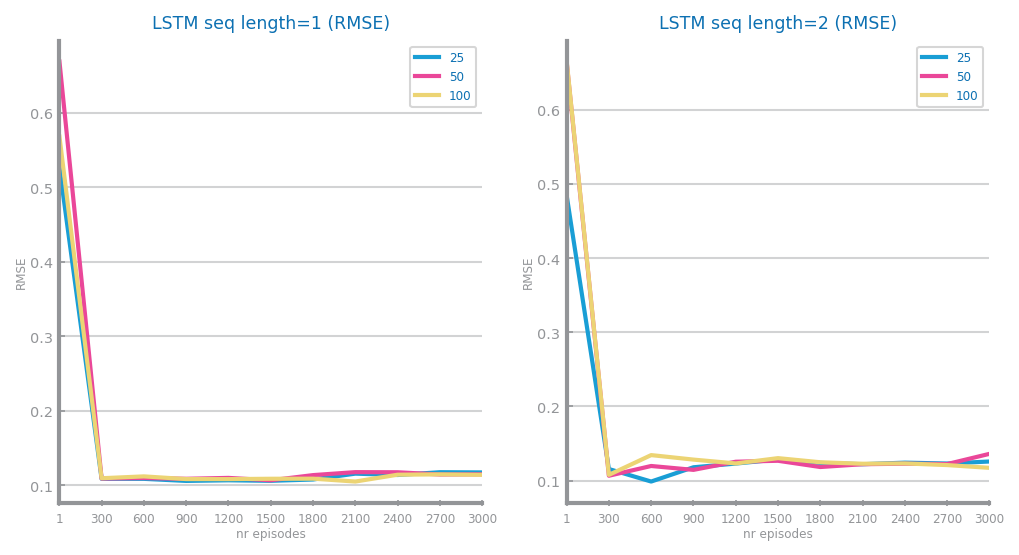

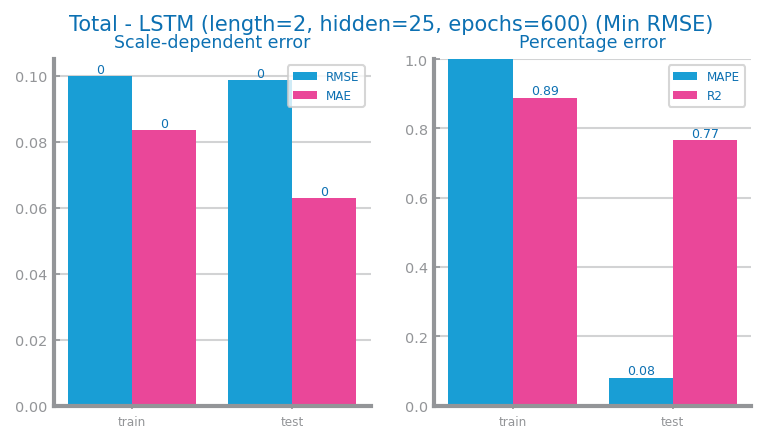

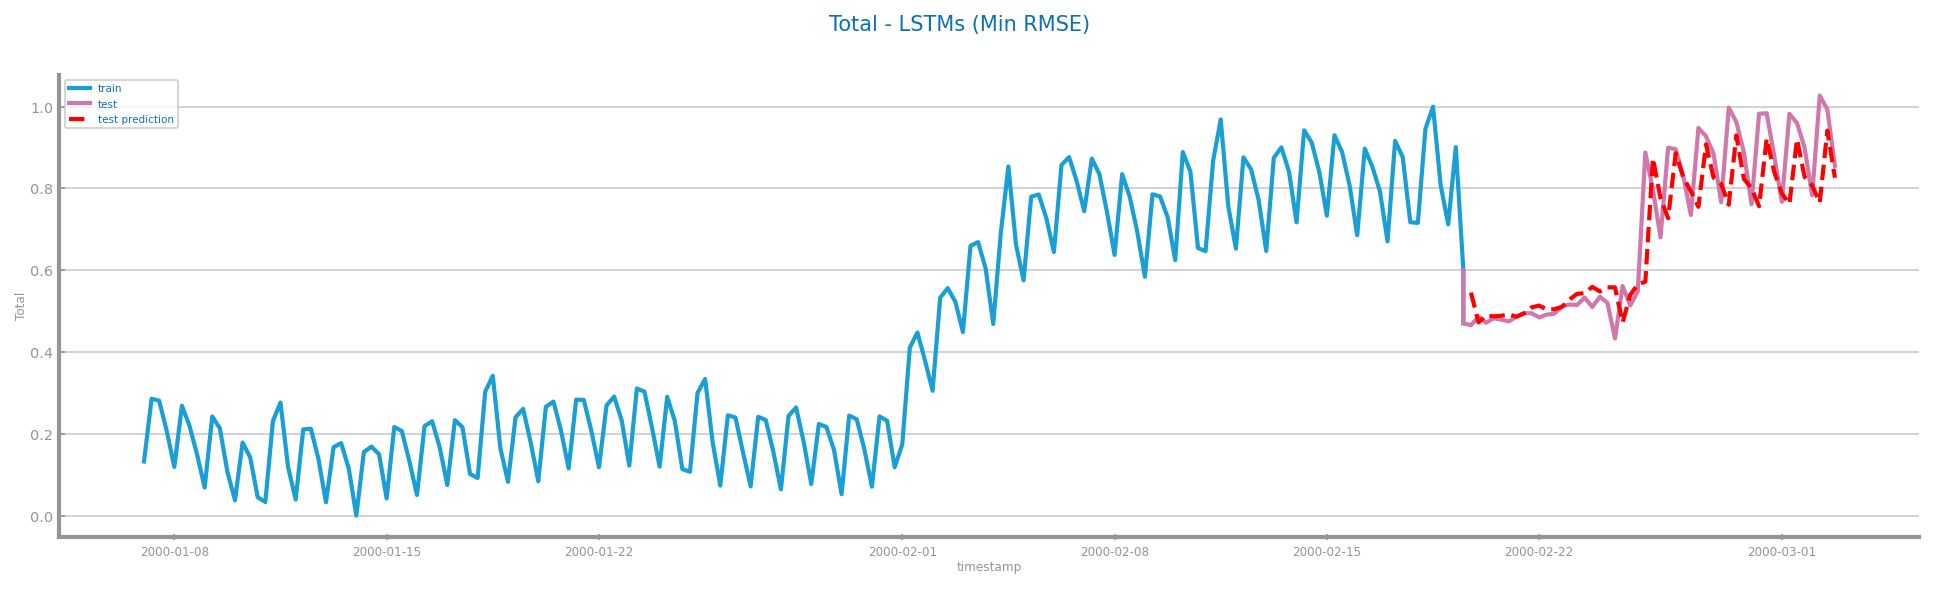

seq length=1 hidden_units=25 nr_episodes=0 0.8351773619651794
seq length=1 hidden_units=25 nr_episodes=300 0.06845204532146454
seq length=1 hidden_units=25 nr_episodes=600 0.06991004198789597
seq length=1 hidden_units=25 nr_episodes=900 0.069733627140522
seq length=1 hidden_units=25 nr_episodes=1200 0.06718367338180542
seq length=1 hidden_units=25 nr_episodes=1500 0.0678323283791542
seq length=1 hidden_units=25 nr_episodes=1800 0.07595235854387283
seq length=1 hidden_units=25 nr_episodes=2100 0.09383763372898102
seq length=1 hidden_units=25 nr_episodes=2400 0.09783343970775604
seq length=1 hidden_units=25 nr_episodes=2700 0.09822166711091995
seq length=1 hidden_units=25 nr_episodes=3000 0.0976986512541771
seq length=1 hidden_units=50 nr_episodes=0 0.5541849732398987
seq length=1 hidden_units=50 nr_episodes=300 0.07150737941265106
seq length=1 hidden_units=50 nr_episodes=600 0.06920604407787323
seq length=1 hidden_units=50 nr_episodes=900 0.06853515654802322
seq length=1 hidden_units=50

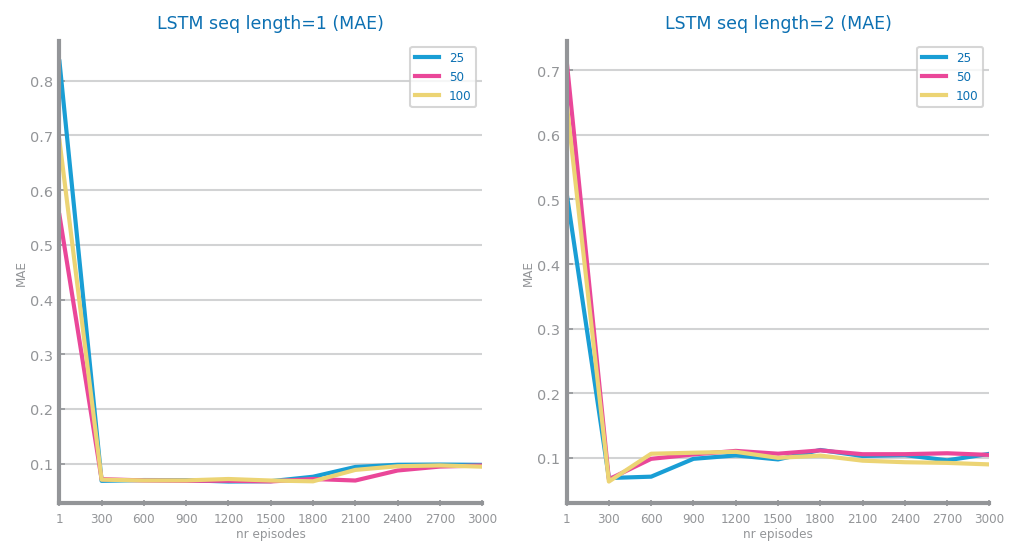

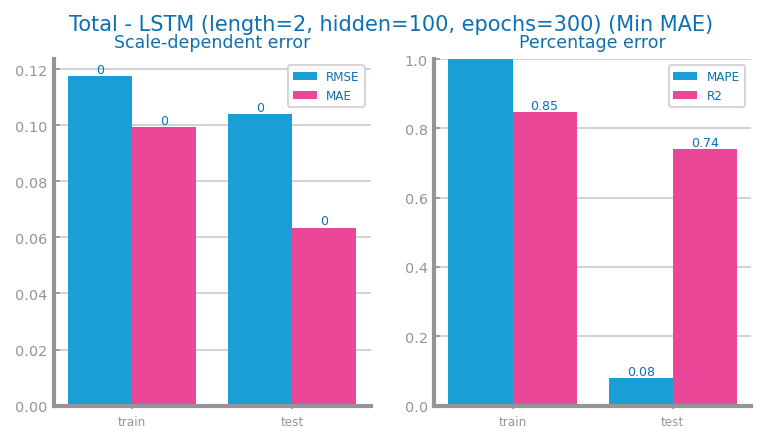

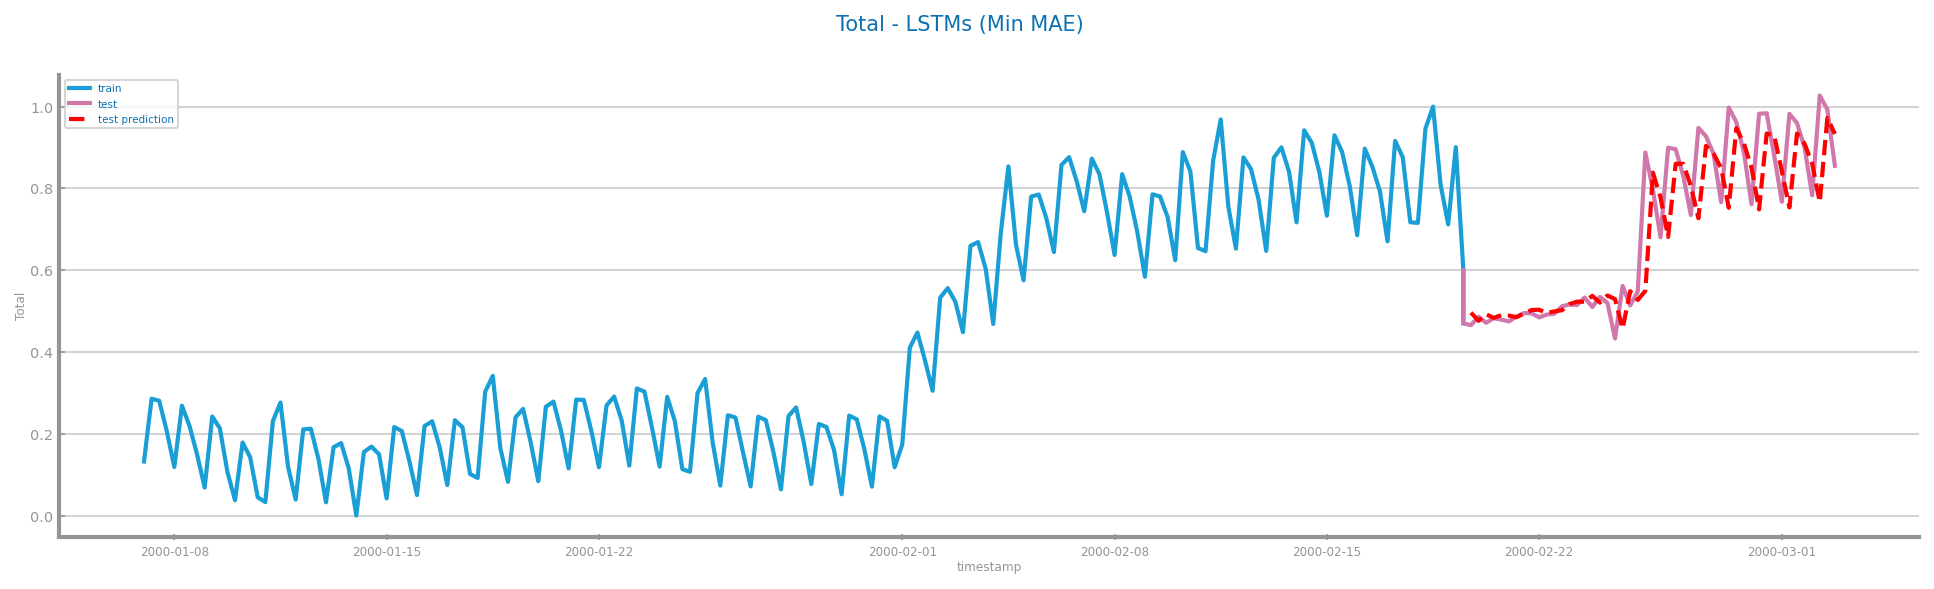

In [11]:
measures = ["RMSE", "MAE"]
for measure in measures:
    best_model, best_params = lstm_study_inflation(train_lstm, test_lstm, nr_episodes=3000, measure=measure)
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_study.png")
    show()

    params = best_params["params"]
    best_length = params[0]
    trnX, trnY = prepare_dataset_for_lstm_inflation(train_lstm, seq_length=best_length)
    tstX, tstY = prepare_dataset_for_lstm_inflation(test_lstm, seq_length=best_length)

    prd_trn = best_model.predict(trnX).detach().cpu().numpy().ravel()
    prd_tst = best_model.predict(tstX).detach().cpu().numpy().ravel()

    plot_forecasting_eval(
        train_lstm[best_length:],
        test_lstm[best_length:],
        prd_trn,
        prd_tst,
        title=f"{chart_target} - LSTM (length={best_length}, hidden={params[1]}, epochs={params[2]}) (Min {measure})",
    )
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_eval.png")
    show()

    pred_full = np.full(len(test), np.nan, dtype=float)
    pred_full[best_length:] = prd_tst

    pred_series = Series(pred_full, index=test.index)

    plot_forecasting_series(
        train,
        test,
        pred_series,
        title=f"{chart_target} - LSTMs (Min {measure})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_lstms_{measure}_forecast.png")
    show()

## LSTM with Multivariate Input (Exogenous Variables)

seq length=2 hidden_units=25 nr_episodes=0 n_features=5 -12.066832542419434
seq length=2 hidden_units=25 nr_episodes=300 n_features=5 0.8185338377952576
seq length=2 hidden_units=25 nr_episodes=600 n_features=5 0.7925917506217957
seq length=2 hidden_units=25 nr_episodes=900 n_features=5 0.7625209093093872
seq length=2 hidden_units=25 nr_episodes=1200 n_features=5 0.7553969621658325
seq length=2 hidden_units=25 nr_episodes=1500 n_features=5 0.7335721254348755
seq length=2 hidden_units=25 nr_episodes=1800 n_features=5 0.7354123592376709
seq length=2 hidden_units=25 nr_episodes=2100 n_features=5 0.7323623895645142
seq length=2 hidden_units=25 nr_episodes=2400 n_features=5 0.7329187393188477
seq length=2 hidden_units=25 nr_episodes=2700 n_features=5 0.7376246452331543
seq length=2 hidden_units=25 nr_episodes=3000 n_features=5 0.7275186777114868
seq length=2 hidden_units=50 nr_episodes=0 n_features=5 -11.679281234741211
seq length=2 hidden_units=50 nr_episodes=300 n_features=5 0.85054689645

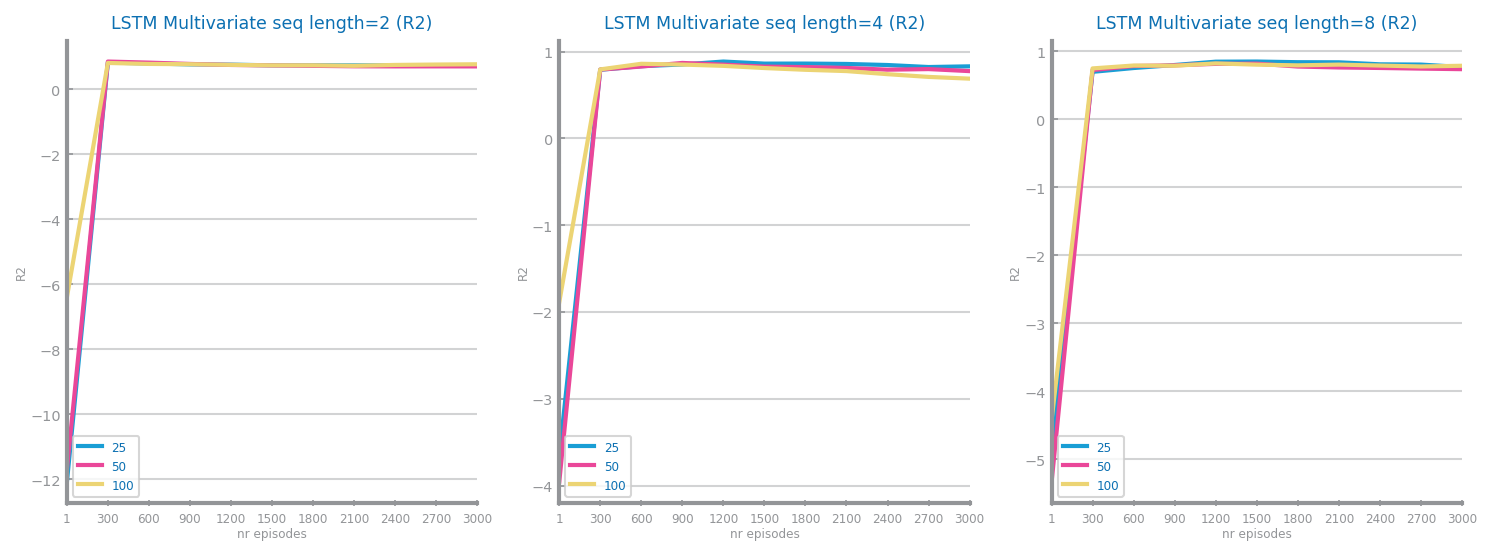

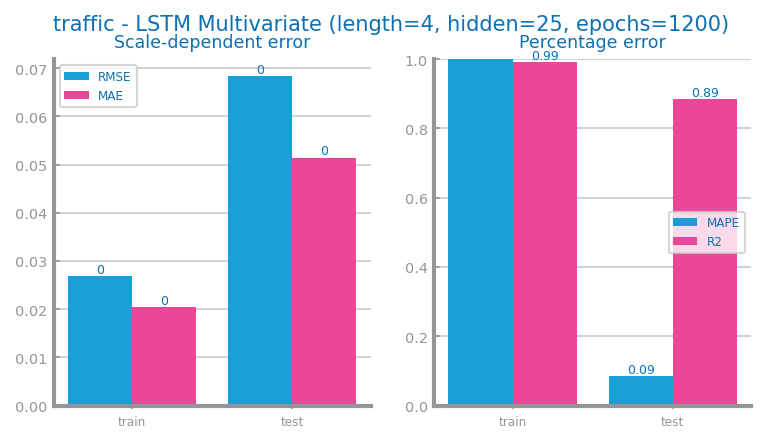

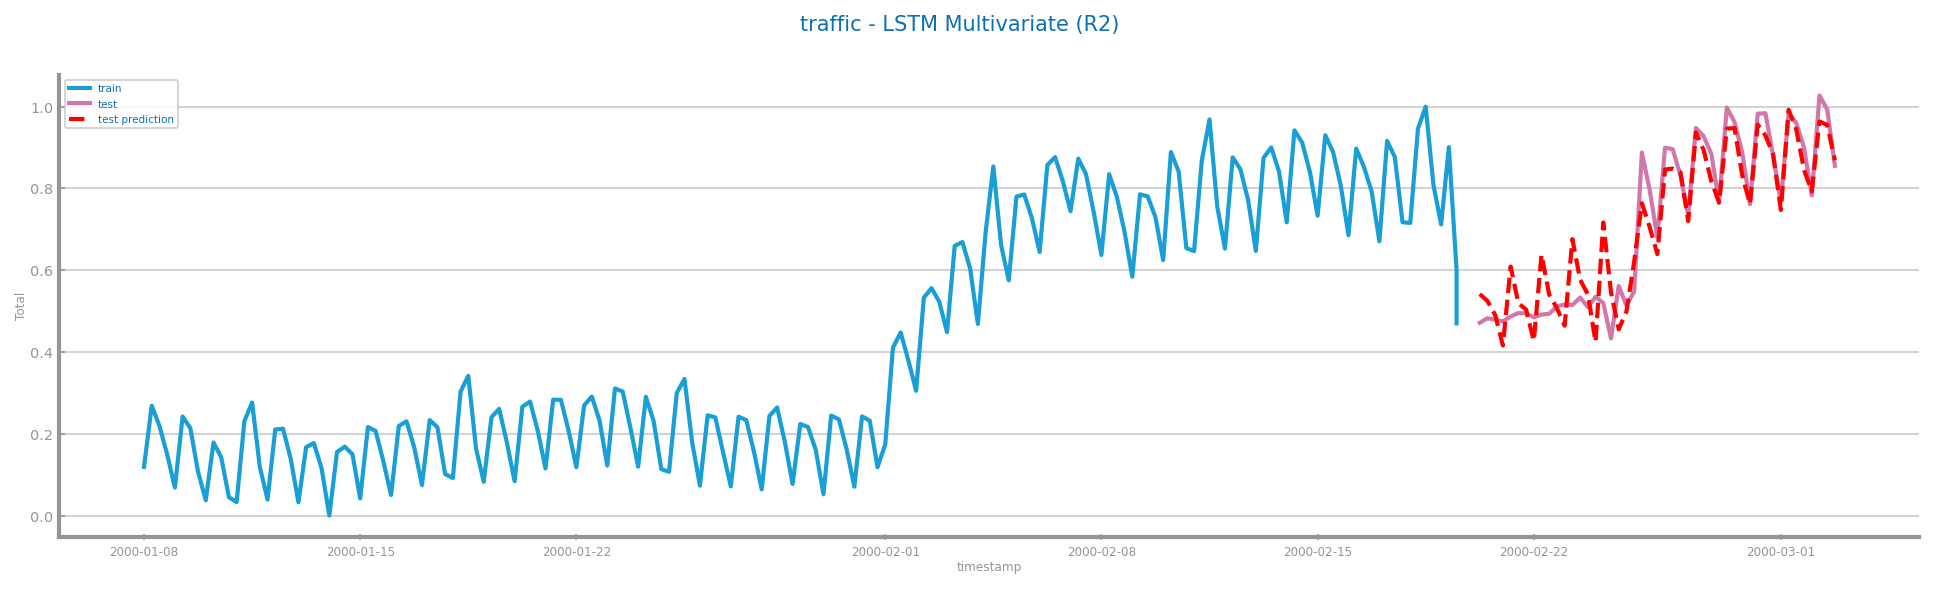

seq length=2 hidden_units=25 nr_episodes=0 n_features=5 1.0284978151321411
seq length=2 hidden_units=25 nr_episodes=300 n_features=5 0.11238612234592438
seq length=2 hidden_units=25 nr_episodes=600 n_features=5 0.10502754896879196
seq length=2 hidden_units=25 nr_episodes=900 n_features=5 0.10921265184879303
seq length=2 hidden_units=25 nr_episodes=1200 n_features=5 0.11489247530698776
seq length=2 hidden_units=25 nr_episodes=1500 n_features=5 0.12509512901306152
seq length=2 hidden_units=25 nr_episodes=1800 n_features=5 0.13127508759498596
seq length=2 hidden_units=25 nr_episodes=2100 n_features=5 0.1330549418926239
seq length=2 hidden_units=25 nr_episodes=2400 n_features=5 0.13207153975963593
seq length=2 hidden_units=25 nr_episodes=2700 n_features=5 0.13417500257492065
seq length=2 hidden_units=25 nr_episodes=3000 n_features=5 0.14350861310958862
seq length=2 hidden_units=50 nr_episodes=0 n_features=5 0.7637045979499817
seq length=2 hidden_units=50 nr_episodes=300 n_features=5 0.1240

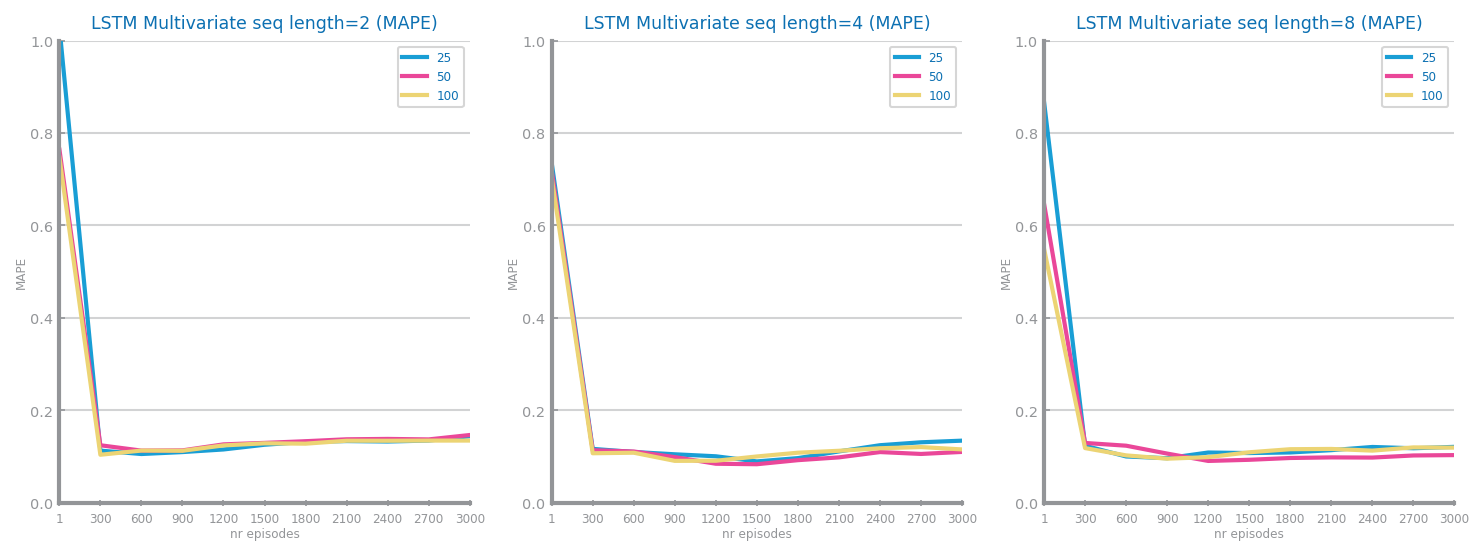

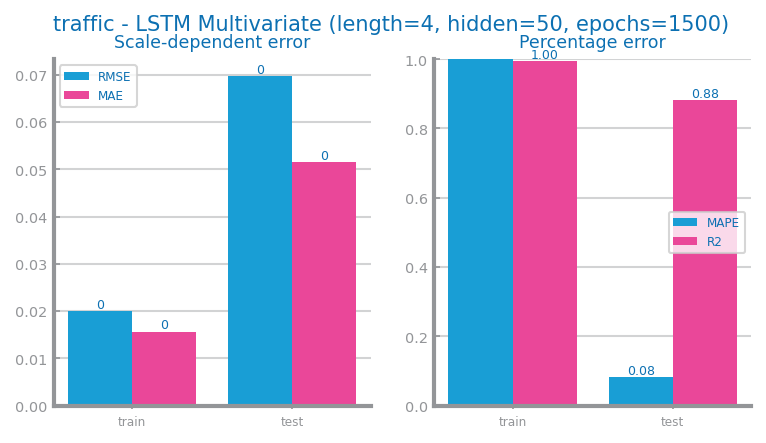

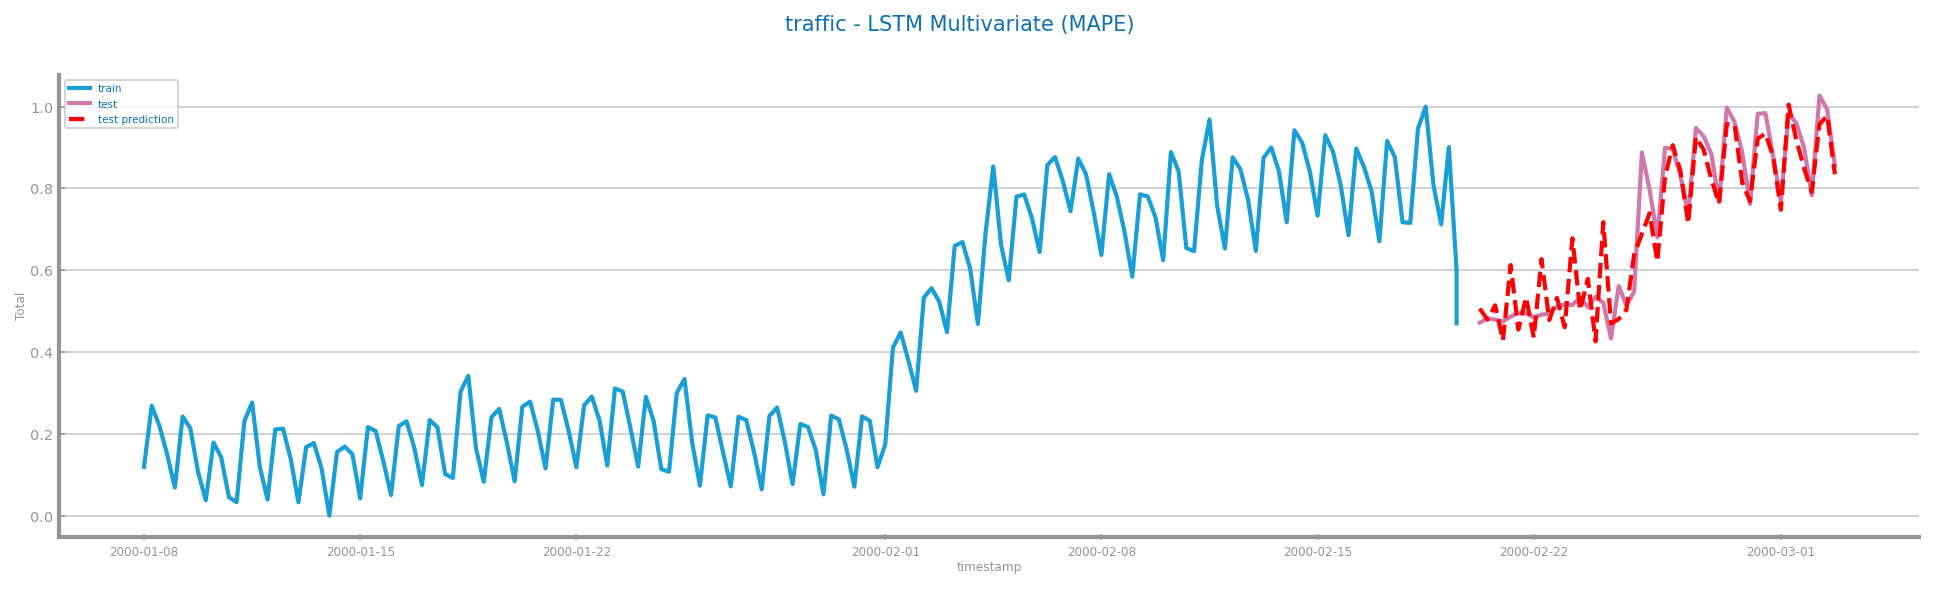

In [12]:
measures = ["R2", "MAPE"]
for measure in measures:
    # LSTM with multivariate input (all features)
    best_model, best_params = lstm_study_multivariate(
        train_df, test_df, target_col=target, nr_episodes=3000, measure=measure
    )
    savefig(f"../charts/forecasting/{file_tag}_lstm_multivariate_{measure}_study.png")
    show()

    params = best_params["params"]
    best_length = params[0]
    trnX, trnY = prepare_multivariate_dataset_for_lstm(train_df, target, seq_length=best_length)
    tstX, tstY = prepare_multivariate_dataset_for_lstm(test_df, target, seq_length=best_length)

    prd_trn = best_model.predict(trnX).detach().cpu().numpy().ravel()
    prd_tst = best_model.predict(tstX).detach().cpu().numpy().ravel()

    plot_forecasting_eval(
        train[best_length:],
        test[best_length:],
        prd_trn,
        prd_tst,
        title=f"{file_tag} - LSTM Multivariate (length={best_length}, hidden={params[1]}, epochs={params[2]})",
    )
    savefig(f"../charts/forecasting/{file_tag}_lstm_multivariate_{measure}_eval.png")
    show()

    pred_series = Series(prd_tst, index=test.index[best_length:])

    plot_forecasting_series(
        train[best_length:],
        test[best_length:],
        pred_series,
        title=f"{file_tag} - LSTM Multivariate ({measure})",
        xlabel=timecol,
        ylabel=target,
    )
    savefig(f"../charts/forecasting/{file_tag}_lstm_multivariate_{measure}_forecast.png")
    show()